In [1]:
#Python-related imports
from datetime import datetime

#PyData imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
from tqdm.notebook import tqdm
from scipy.optimize import bisect

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)
    
from TruncatedNormal import *
from LogitNormal import *
from obs_and_flow import LowerBound
from SBM_SDE_classes_optim import *

In [3]:
torch.manual_seed(0)
np.random.seed(0)

torch.set_printoptions(precision = 8)

## Sample $\theta$
Define target prior means and stddevs.

In [14]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

prior_scale_factor = 0.333

#Parameter prior means
u_M_mean = 0.00012
a_SD_mean = 0.5
a_DS_mean = 0.5
a_M_mean = 0.5
a_MSC_mean = 0.5
k_S_ref_mean = 0.0001
k_D_ref_mean = 0.0005
k_M_ref_mean = 0.0002
Ea_S_mean = 50
Ea_D_mean = 45
Ea_M_mean = 45
s_SOC_mean = 0.001
s_DOC_mean = 0.001
s_MBC_mean = 0.001

#SCON theta truncated normal distribution parameter details in order of mean, sdev, lower, and upper.
u_M_details = torch.Tensor([u_M_mean, u_M_mean * prior_scale_factor, 0, 1])
a_SD_details = torch.Tensor([a_SD_mean, a_SD_mean * prior_scale_factor, 0, 1])
a_DS_details = torch.Tensor([a_DS_mean, a_DS_mean * prior_scale_factor, 0, 1])
a_M_details = torch.Tensor([a_M_mean, a_M_mean * prior_scale_factor, 0, 1])
a_MSC_details = torch.Tensor([a_MSC_mean, a_MSC_mean * prior_scale_factor, 0, 1])
k_S_ref_details = torch.Tensor([k_S_ref_mean, k_S_ref_mean * prior_scale_factor, 0, 1])
k_D_ref_details = torch.Tensor([k_D_ref_mean, k_D_ref_mean * prior_scale_factor, 0, 1])
k_M_ref_details = torch.Tensor([k_M_ref_mean, k_M_ref_mean * prior_scale_factor, 0, 1])
Ea_S_details = torch.Tensor([Ea_S_mean, Ea_S_mean * prior_scale_factor, 0, 100])
Ea_D_details = torch.Tensor([Ea_D_mean, Ea_D_mean * prior_scale_factor, 0, 100])
Ea_M_details = torch.Tensor([Ea_M_mean, Ea_M_mean * prior_scale_factor, 0, 100])

#SCON-SS diffusion matrix parameter distribution details
s_SOC_details = torch.Tensor([s_SOC_mean, s_SOC_mean * prior_scale_factor, 0, 1])
s_DOC_details = torch.Tensor([s_DOC_mean, s_DOC_mean * prior_scale_factor, 0, 1])
s_MBC_details = torch.Tensor([s_MBC_mean, s_MBC_mean * prior_scale_factor, 0, 1])

In [15]:
priors = {'u_M': u_M_details, 'a_SD': a_SD_details, 'a_DS': a_DS_details, 'a_M': a_M_details, 'a_MSC': a_MSC_details, 'k_S_ref': k_S_ref_details, 'k_D_ref': k_D_ref_details, 'k_M_ref': k_M_ref_details, 'Ea_S': Ea_S_details, 'Ea_D': Ea_D_details, 'Ea_M': Ea_M_details, 's_SOC': s_SOC_details, 's_DOC': s_DOC_details, 's_MBC': s_MBC_details}

Find logit normal (parent) loc and scale parameters that would roughly correspond to the target means and stddevs.

In [16]:
def find_scale(scale, loc, a, b, target_sd):
    x = RescaledLogitNormal(loc, scale, a, b)
    #print(scale, x.mean, x.stddev)
    return x.stddev - target_sd

In [17]:
def sample_theta(priors):
    torch.manual_seed(0)
    scale_lower = 1e-8 #Lower bound for scale search by bisect function.
    scale_upper = 100 #Upper bound for scale search by bisect function. 
    
    theta_hyperparams = {} # hyperparams
    theta_samples = {} # theta samples
    for k, v in priors.items():
        print(k)
        sigmoid_loc, target_sd, a, b = v
        loc = logit(sigmoid_loc, a, b)
        scale = bisect(find_scale, scale_lower, scale_upper, (loc, a, b, target_sd))
        dist = RescaledLogitNormal(loc, scale, a, b)
        assert torch.abs(dist.stddev - target_sd) < 1e-5, dist.stddev - target_sd
        
        theta_hyperparams[k] = torch.tensor((loc, scale, a, b))
        theta_samples[k] = dist.sample()
        
    return theta_hyperparams, theta_samples

In [18]:
theta_hyperparams, theta_samples = sample_theta(priors)

u_M
a_SD
a_DS
a_M
a_MSC
k_S_ref
k_D_ref
k_M_ref
Ea_S
Ea_D
Ea_M
s_SOC
s_DOC
s_MBC


Plot sampled theta and its prior distribution.

In [19]:
keys = list(theta_hyperparams.keys())
loc, scale, a, b = torch.tensor(list(zip(*(theta_hyperparams[k] for k in keys))))
loc, scale, a, b

(tensor([-9.02789879,  0.00000000,  0.00000000,  0.00000000,  0.00000000,
         -9.21024036, -7.60040236, -8.51699257,  0.00000000, -0.20067078,
         -0.20067078, -6.90675497, -6.90675497, -6.90675497]),
 tensor([0.30985758, 0.74646717, 0.74646717, 0.74646717, 0.74646717, 0.30984986,
         0.31000444, 0.30988830, 0.74646717, 0.66262418, 0.66262418, 0.31019765,
         0.31019765, 0.31019765]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1., 100., 100., 100.,   1.,
           1.,   1.]))

In [20]:
target_means, target_sds, _, _ = torch.tensor(list(zip(*(priors[k] for k in keys))))

In [21]:
dist = RescaledLogitNormal(loc, scale, a, b)
x0 = torch.max(target_means - 4*target_sds, a).detach()
x1 = torch.min(target_means + 4*target_sds, b).detach()

num_pts = 1000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf = torch.exp(dist.log_prob(x)).detach()

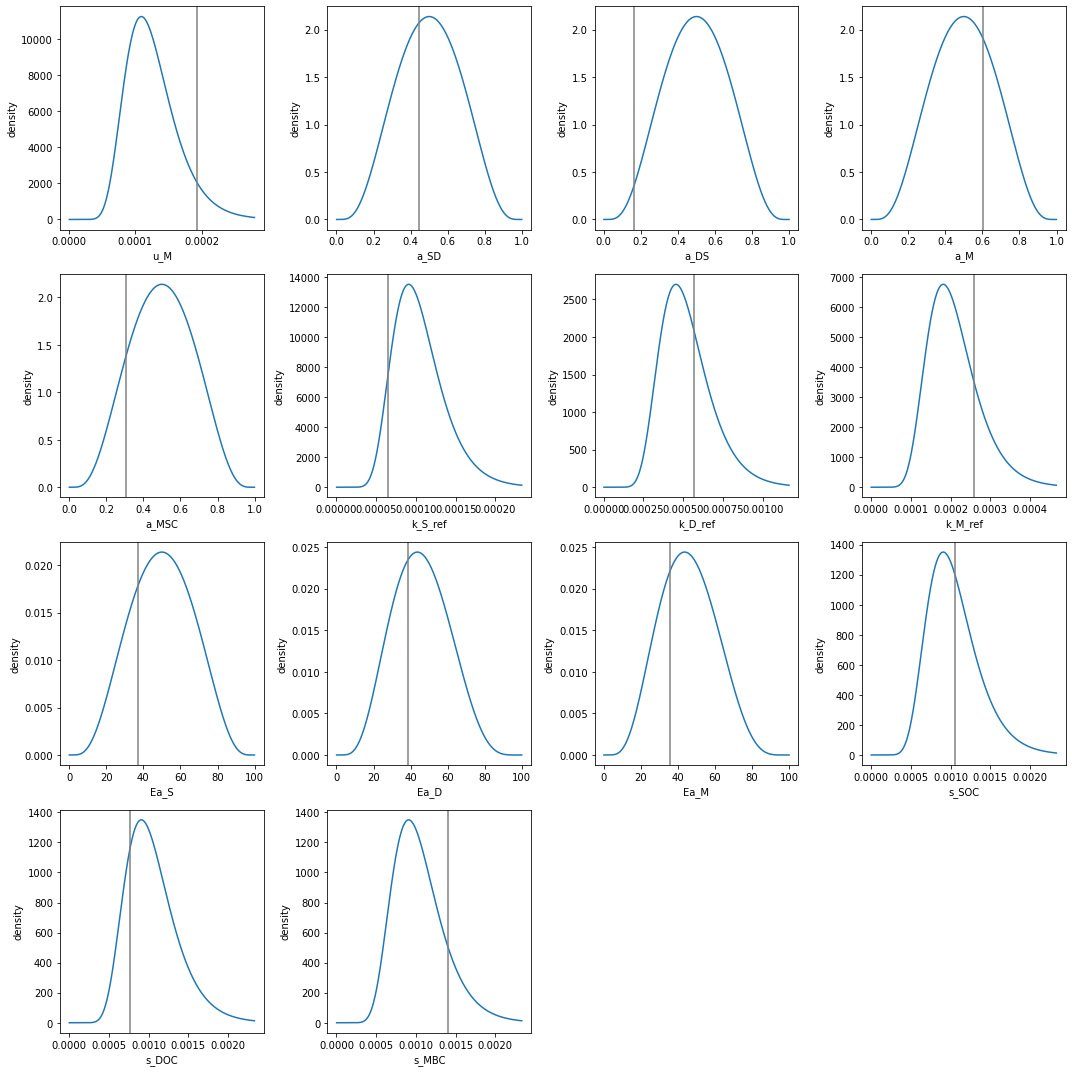

In [24]:
# Plot sampled theta values
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
k = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if k < 14:
            key = keys[k]
            ax.plot(x[:, k], pdf[:, k])
            ax.axvline(theta_samples[key], color='gray')
            ax.set_xlabel(key)
            ax.set_ylabel('density')
        else:
            fig.delaxes(axes[i, j])
        k += 1  
plt.tight_layout()

## Sample $x, y|\theta$

In [25]:
def generate_data(SBM_SDE_CLASS, DIFFUSION_TYPE, X0_LOC, X0_SCALE, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, seed=0):    
    # Vectorize variable calculations where possible
    N = int(T / DT) + 1
    hours = torch.tensor(np.linspace(0, T, N), dtype=torch.float) # 0
    I_S_tensor = I_S_FUNC(hours)
    I_D_tensor = I_D_FUNC(hours)
    temps = TEMP_FUNC(hours, TEMP_REF, TEMP_RISE)
    model = SBM_SDE_CLASS(hours, I_S_tensor, I_D_tensor, temps.unsqueeze(-1), TEMP_REF, DIFFUSION_TYPE)
    
    # Draw initial condition x0 ~ N(loc=X0_LOC, scale=X0_LOC * X0_SCALE)
    x = torch.empty([N, model.state_dim])
    X0_LOC = torch.as_tensor(X0_LOC)
    p_x0 = TruncatedNormal(loc = X0_LOC, scale = X0_LOC * X0_SCALE, a = 0, b = float('inf'))
    x0_samples = p_x0.sample() # (state_dim, )
    print('X0_samples = ', x0_samples)
    x[0, :] = x0_samples
    
    #Take Euler-Maruyama step. 
    for i in tqdm(range(1, N)):
        # Define x_i ~ N(loc = x_prev + alpha(x_prev, theta)*dt, scale = sqrt(beta(x_prev, theta)*dt))
        a = model.calc_drift(x[i - 1, :], THETA_DICT, I_S_tensor[i], I_D_tensor[i], temps[i])
        b = model.calc_diffusion_sqrt(x[i - 1, :], THETA_DICT, diffusion_matrix=False)
        #a = ALPHA(x[:, i - 1, :], THETA_DICT, I_S_tensor[i], I_D_tensor[i], temps[i], TEMP_REF, arrhenius_temp_dep, linear_temp_dep)
        #b = BETA(x[:, i - 1, :], THETA_DICT, diffusion_matrix=False)
        p_x_i = TruncatedNormal(loc = x[i - 1, :] + a * DT, scale = b * math.sqrt(DT), a = 0, b = float('inf'))
        
        # Draw sample
        x[i, :] = p_x_i.sample()
        
    # Compute CO2
    x_for_y = x[0::int(OBS_EVERY / DT), :] #Slice x based on observation interval to generate y.
    CO2 = model.calc_CO2(x_for_y, THETA_DICT, int(OBS_EVERY / DT)) # after or before subsampling, can self.temps, etc. work for subsampled time steps?
    x_with_CO2_for_y = torch.cat((x_for_y, CO2), dim=-1) # (n, state_dim + 1)
    
    # Generate y ~ N(x, OBS_ERROR_SCALE * mean(x))
    obs_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(0) # (state_dim, )
    y = TruncatedNormal(x_with_CO2_for_y, obs_scale.reshape((1, -1)), 0, float('inf')).sample()
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_scale, 'x': x, 't_x': np.arange(0, T + DT, DT),
            'CO2': CO2, 't_CO2': np.arange(0, T + DT, OBS_EVERY), 'p_x0': p_x0}

In [26]:
dt = 0.1
t = 100000
x0_SCON = [65, 0.4, 2.5]
obs_every = 5
obs_error_scale = 0.1

In [28]:
y_dict = generate_data(SCON_optim, 'SS', x0_SCON, obs_error_scale, t, dt, theta_samples, i_s, i_d,
                       temp_gen, temp_ref, temp_rise, obs_every, obs_error_scale)

X0_samples =  tensor([59.17854691,  0.38708737,  2.37255311])



torch.Size([20001, 1])
torch.Size([20001, 1])


In [32]:
def plot_path(x, y, t_x, t_y, title=None):
    time_steps, state_dim = x.shape
    fig, axes = plt.subplots(state_dim + 1, figsize=(15, 15), sharex=True)
    
    labels = ['SOC', 'DOC', 'MBC', 'CO2']
    colors = ['m', 'c', 'g', 'orange']
    for i, ax in enumerate(axes):            
        # Only plot observations for CO2 (since it is not a state)
        if i < state_dim:
            ax.plot(t_x, x[:, i], color=colors[i], label='latent state')
        ax.plot(t_y, y[:, i], alpha=0.3, color=colors[i], label='obervation')
        
        ax.set_ylabel(labels[i])
        ax.legend()
        if i == 0 and title:
            ax.set_title(title)
    ax.set_xlabel('hour')
    plt.tight_layout()

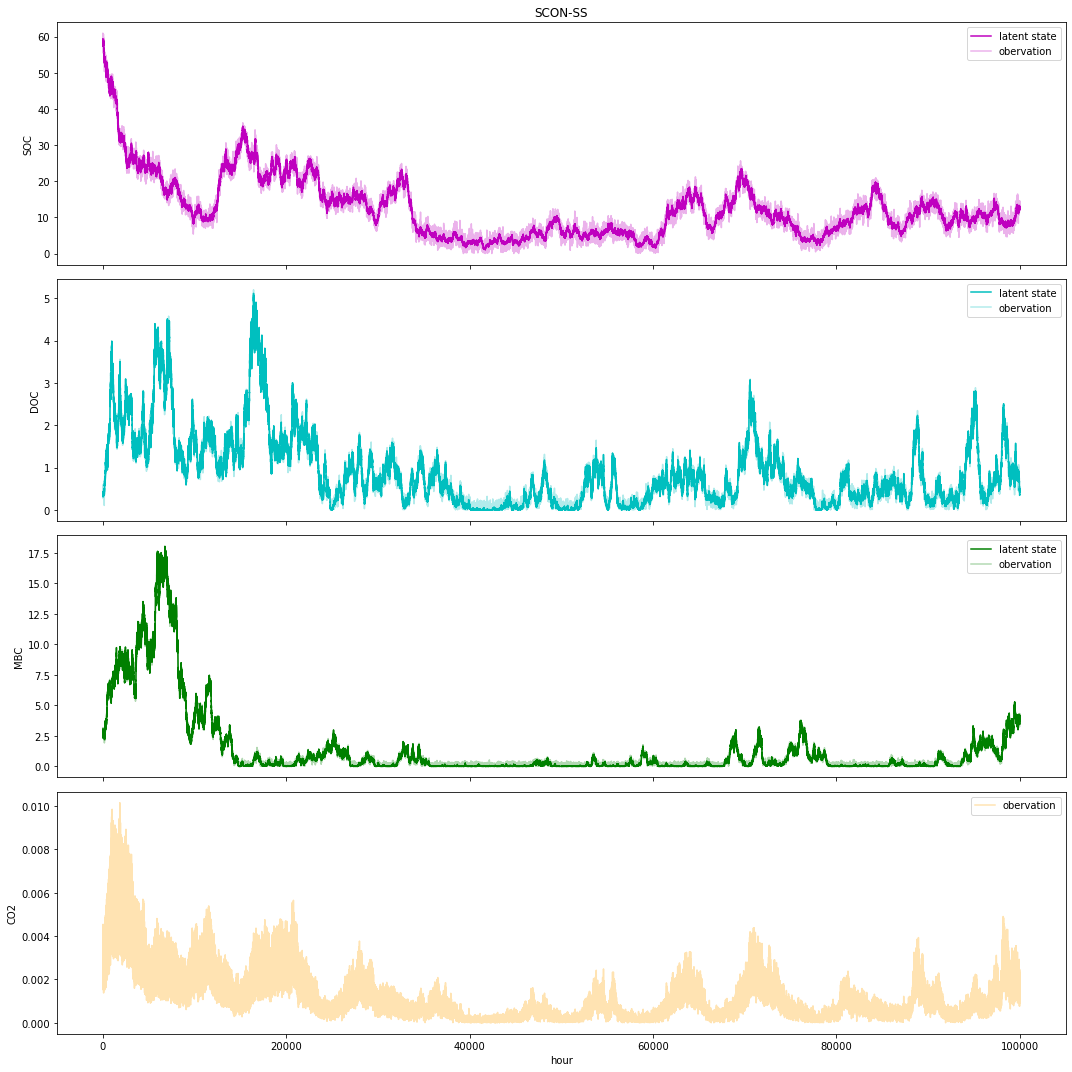

In [33]:
x, t_x = y_dict['x'], y_dict['t_x']
y, t_y = y_dict['y'], y_dict['t_y']
plot_path(x, y, t_x, t_y, 'SCON-SS')

## Save generated data

In [35]:
save_dir = 'data/dt_01_t_100000_minibatch_logit_theta_trunc_trans/SCON_SS'
target_hyperparams_file = save_dir.format('target_hyperparams')
hyperparams_file = '{}_hyperparams.pt'.format(save_dir)
theta_file = '{}_theta.pt'.format(save_dir)
x_file = '{}_x.pt'.format(save_dir)
x0_dist_file = '{}_x0_dist.pt'.format(save_dir)
y_dict_file = '{}_y_dict.pt'.format(save_dir)

torch.save(priors, target_hyperparams_file)
torch.save(theta_hyperparams, hyperparams_file)
torch.save(theta_samples, theta_file)
torch.save(x, x_file)
torch.save(y_dict['p_x0'], x0_dist_file)
torch.save(y_dict, y_dict_file)

In [36]:
x.shape

torch.Size([1000001, 3])

## Archive

In [ ]:
now = datetime.now()
sbm_model = 'SCON-SS_CO2_trunc' + now.strftime('_%Y_%m_%d_%H_%M')
dir_path = '../generated_data/'
save_string = dir_path + f'{sbm_model}_sample_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
save_string_x = dir_path + f'{sbm_model}_sample_x_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig.savefig(save_string + '.png', dpi = 300)

In [ ]:
#Save CSV of stochastic path.
df_y = pd.DataFrame(data = {'hour': y_dict['t_y'], 'SOC': y_dict['y'][0, :], 'DOC': y_dict['y'][1, :], 'MBC': y_dict['y'][2, :], 'CO2': y_dict['y'][3, :]})
df_y.to_csv(save_string + '.csv', index = False)

In [ ]:
print(np.max(df_y['SOC']))
print(np.max(df_y['DOC']))
print(np.max(df_y['MBC']))
print(np.max(df_y['CO2']))

In [ ]:
#Save rsampled theta values.
torch.save(SCON_SS_params_dict, save_string + '_rsample.pt')

#Save priors dict.
torch.save(SCON_SS_priors_dict, save_string + '_hyperparams.pt')

In [ ]:
print(df_y)

In [ ]:
y_det_dict = get_SBM_SDE_euler_maruyama_y_det(alpha_SCON, x0_SCON, t, dt, SCON_SS_params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

In [ ]:
fig2, axs2 = plt.subplots(4, sharex = True)
axs2[0].plot(y_det_dict['t_x'], y_det_dict['x'][0, :], color = "m", label = 'SOC x')
axs2[0].scatter(y_det_dict['t_y'], y_det_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs2[1].plot(y_det_dict['t_x'], y_det_dict['x'][1, :], color = "c", label = 'DOC x')
axs2[1].scatter(y_det_dict['t_y'], y_det_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs2[2].plot(y_det_dict['t_x'], y_det_dict['x'][2, :], color = "g", label = 'MBC x')
axs2[2].scatter(y_det_dict['t_y'], y_det_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs2[3].plot(y_det_dict['t_x'], y_det_dict['x'][3, :], color = "orange", label = 'CO2')
axs2[3].scatter(y_det_dict['t_y'], y_det_dict['y'][3, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [ ]:
save_string_det = dir_path + f'{sbm_model}_sample_det_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig2.savefig(save_string_det + '.png', dpi = 300)

In [ ]:
df_y_det = pd.DataFrame(data = {'hour': y_det_dict['t_y'], 'SOC': y_det_dict['y'][0, :], 'DOC': y_det_dict['y'][1, :], 'MBC': y_det_dict['y'][2, :], 'CO2': y_det_dict['y'][3, :]})
df_y_det.to_csv(save_string_det + '.csv', index = False)

In [ ]:
print(df_y_det)

In [ ]:
TruncatedNormal(0, 1, 0, float('inf'))